In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# 데이터 불러오기 및 전처리

분류 문제와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

각 픽셀이 0~255 사이의 정수값을 가지는지 확인한다.

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


각 픽셀을 -1, 1로 정규화시켜 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 뒤 127.5로 나눠준다.

In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

train dataset에는 3채널을 가진(rgb) 32x32사이즈의 이미지 5만 장이 들어있다.

전처리를 마친 데이터를 꺼내 시각화하여 확인해본다.

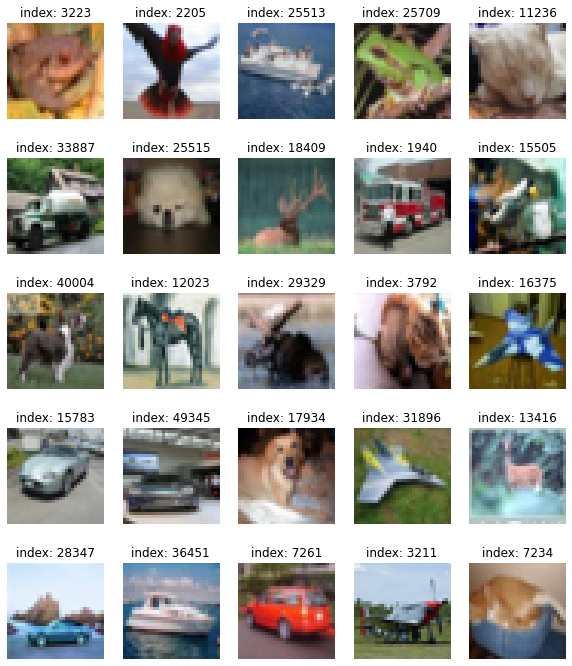

In [6]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_i = np.random.randint(1, 50000)
    plt.imshow((train_x[random_i]+1)/2.0)
    plt.title(f'index: {random_i}')
    plt.axis('off')
plt.show()

데이터를 섞고 배치 사이즈에 따라 나눈다.

In [7]:
BUFFER_SIZE = 50000 #전체 데이터를 섞기 위해 5만으로 설정
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print('complete')

complete


# 생성자 구현하기

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer - convolutional 연산이 가능하도록 3차원 벡터로 변환
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

Conv2DTranspose층은 일반적인 Conv2D와 반대로 이미지를 넓혀주는 층이다.
BatchNomalization레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜준다.
활성화 함수는 모두 LeakyReLU를 사용했지만 마지막층엔 tanh를 사용하는데, -1 ~ 1이내의 값으로 픽셀을 정규화시켰던 데이터셋과 동일하게 하기 위함이다.

모델을 생성하고 summary를 출력해본다.

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

# 결과물 만들어 보기

In [11]:
noise = tf.random.normal([1, 100]) #랜덤 벡터로 이루어진 노이즈 벡터 만들기

In [12]:
generated_image = generator(noise, training=False) #학습하는 중이 아니므로 training=False
generated_image.shape

TensorShape([1, 32, 32, 3])

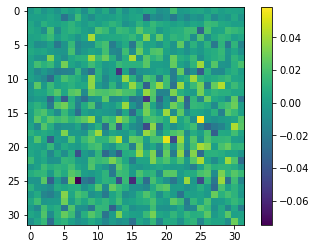

In [13]:
plt.imshow(generated_image[0, :, :, 0]) #matplotlib라이브러리는 2차원 이미지만 보여줄 수 있다.
plt.colorbar()
plt.show()

# 판별자 구현하기

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

모델을 생성하고 summary를 출력해본다.

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

위에서 생성한 결과물 이미지(가짜 이미지)를 판별자에 입력시켜본다.

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0010549]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 된다. 아직은 아무런 의미가 없는 값이다.

# 손실함수(loss function)

GAN은 손실함수로 교차 엔트로피(점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지 정량적으로 계산할 때 사용)를 사용한다.
특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피를 사용할 것이다.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

판별자 모델의 마지막 레이어에 값을 정규화시키는 활성화 함수가 없었다.
그러나 tf.keras.losses의 BinaryCrossEntropy클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1사이에 분포하는 확률값이라고 가정한다.
따라서 from_logits을 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid함수를 사용해 0~1사이 값으로 정규화한 후 알맞게 계산할 수 있다.

### generator_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #fake_output이 real image(1)에 가까울수록 결과값이 작아진다.

tf.ones_like()함수는 특정 벡터와 동일한 크기면서 값은 1로 가득 채워진 벡터를 만들고 싶을 때 사용한다.
generator_loss는 fake_ouput이 1에 가까워지기를 바라므로, 1로 채워진 벡터와의 교차 엔트로피값을 계산하면 된다.

### discriminator_loss

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_loss는 real_output은 1에, fake_output은 0에 가까워지기를 바라므로 두 가지 loss값을 모두 계산한다.
real_output은 1, fake_output은 0으로 채워진 벡터와 비교하면 된다. 최종 discriminator_loss값은 이 둘을 더한 값이다.

### discriminator accuracy

판별자가 real output, fake ouput을 얼마나 정확히 판별하는지 accuracy를 계산해 보는 것도 GAN의 학습에서 중요하다.   
accuracy와 fake accuracy는 초반에 1.0에 가깝게 나오다가, 서서히 낮아져 둘 다 0.5에 가까워지는 것이 이상적이다.

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

real_output의 각 원소가 0.5 이상인지 True, False로 판별한 뒤(tf.math.greater_equal)
결과가 True이면 1.0, False이면 0.0으로 변환하고(tf.cast)
이 결과를 평균내어 이번 배치의 정확도를 계산한다(tf.reduce_mean).

# 최적화 함수(optimizer)

Adam 최적화 기법을 활용한다.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이므로, optimizer를 따로 만들어줘야 한다.

### 생성자가 생성한 샘플 확인

In [22]:
#100차원의 노이즈 총 16개, (16, 100)형상의 벡터를 만들어 둔다.
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

매번 학습이어떻게 진행되어가고 있는지 확인한다.
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어 두어야 한다.

# 훈련과정 설계

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 generate_and_save_images()를 만든다.

In [24]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)

    np_generated = predictions.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_generated[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

위에서 만들어둔 고정된 seed를 통해 결과물을 만들어 내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지 확인할 수 있다.

### loss와 accuracy 그래프 그리기

train_stpe()함수가 반환하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수 draw_train_history()를 만든다.

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### checkpoint 만들기

tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있다.
checkpoint에는 optimizer와 생성자, 판별자(정확히는 생성자와 판별자가 학습한 모델 가중치)를 모두 넣어 저장한다.

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 모델 학습 시키기

한 단계를 학습하는 train_step
샘플 이미지를 생성하고 저장하는 generate_and_save_images()
학습 과정을 시각화하는 draw_train_history()
모델을 저장하는 checkpoint까지 전부 준비했으므로 이를 한곳에 합친다.

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
save_every = 5 #모델 저장 간격
EPOCHS = 1000 #전체 학습 에포크

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

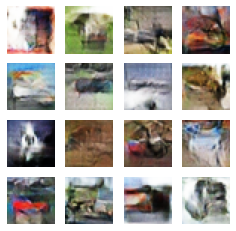

Time for training : 18865 sec


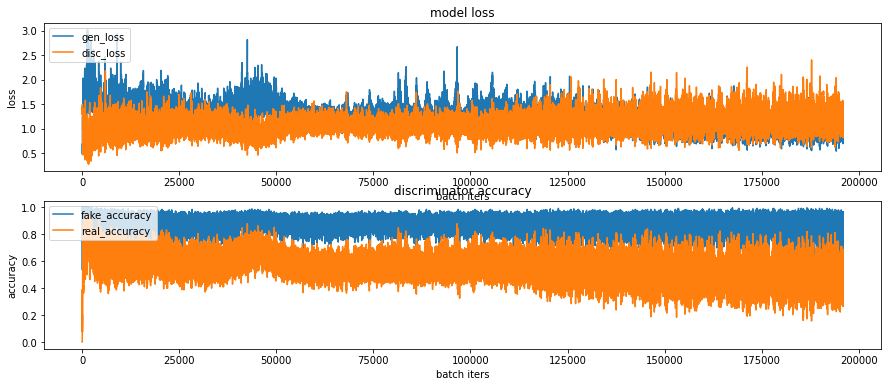

CPU times: user 5h 21min 36s, sys: 27min 59s, total: 5h 49min 35s
Wall time: 5h 14min 36s


In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

위에서 checkpoint 모듈을 이용해 저장한 모델을 이용해, 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 작업을 진행할 수 있다.   

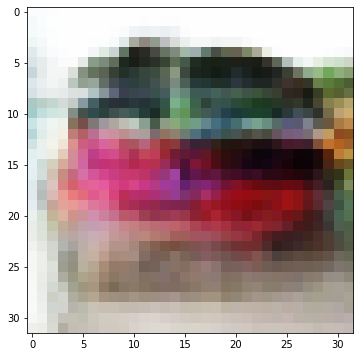

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# 학습과정 시각화

import해놓았던 imageio라이브러리를 활용해 GIF파일을 만들 수 있다.
imageio.get_writer를 활용해 파일을 열고, append_data로 이미지를 하나씩 붙여나가는 방식이다.

In [31]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 4408525 Feb 14 19:42 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


![cifar10_dcgan.gif](~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif)

cifar10_dcgan.gif를 삽입하고 싶은데, 왜 안되는지 모르겠다! 내일 물어봐야지

# 회고

이번 노드를 진행하며 처음으로 야작을 해보았다! 평소 수업 시간이 끝나면 외주작업(영상편집)을 하고 있었기에 물리적으로 시간이 부족해 한 번도 해 본 적 없었는데, 이번에 조원분들이 많이 참석하신다길래 큰 맘 먹고 늦은시간 게더타운에 들어가봤다.   
다른 조에서 야작하는 분들과 "이번 익스는 코드 돌리는 데 너무 오래 걸리지 않냐"라고 이런 저런 대화도 하고, 서로서로 어떻게 하고 있는가 공유하며 즐겁기도 하고 많은 도움을 얻었다. 문제가 생길 때 마다 바로바로 다른분께 물어보면 금방금방 수월하게 해결해서 "이 맛에 야작 하는구나" 생각했다.   
...라고 말한 것 치고, 나는 파라미터 수정 없이(사이즈 변동 & 흑백 이미지에서 컬러 이미지가 되며 필요한 최소의 수정 제외)냅다 epoch를 많이 돌려보기만 했다. 결과물을 얻는 데 시간이 이렇게나 많이 걸리는 과제는 이런 저런 파라미터를 주먹구구로 만져보기 어려워, 시간의 한계에 부딪히기 때문이다. 각 모듈이 어떻게 작동하는지를 명확히 이해하고 필요한 부분만 손보면 시간을 단축할 수 있으나 아직 거기까진 나에게 벅차다. 모르겠으면 하나하나 찍어보고 바꿔보는 방식으로 아직까지 학습하고 있는 중이기 때문이다.   
비록 나는 epoch만 올려 제출하지만 야작 파티원 중 생성자 모델에 레이어를 추가하여 적은 epoch안에 배경과 피사체가 선명히 분리되고 그나마 뭔지 형체를 알아 볼 법도 한 결과물을 얻은 분도, 심지어 모델을 아예 API로 구현하신 분도 계셔서 "저런 방법도 있구나!"하고 얻어가는 것이 정말 많았다. 앞으론 시간을 좀 많이 할당해서라도 야작에 적극 참여해야겠다.   
    
GAN이 원래 다루기가 까다롭고 어렵다고들 말씀하시던데, 이미지를 다루어서 난이도와는 별개로 굉장히 흥미롭고 재미있었다. 특히 StyleGAN같은 경우는 언급으로만 지나갔지만 영상 애니메이션 분야에서 활용도가 아주 아주 높을거라 생각해 더 알고싶어 찾아보기까지 했다(평소엔 추가학습? 꿈으로도 절대 꾸지 않는다). 100%이해보단 맥락을 이해하고 넘기며 수박 겉핥기 학습법을 수행하고 있지만 그래서 지금처럼 궁금한 것에는 에너지를 투자해가며 오래오래 괴롭지 않게 공부한다고 생각한다. 지치고 힘들땐 야작을 하자! 그리고 불안할땐 지금 이 생각을 상기하자!!